<a href="https://colab.research.google.com/github/GabyDs/FirearmShotDetectionSystem/blob/main/FirearmShotDetectionSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
import os

import numpy as np
import pandas as pd
import csv

import scipy
from scipy import signal

import matplotlib.pyplot as plt

import librosa, librosa.display
import IPython.display as ipd


# Dataset

In [ ]:
!wget -c --no-check-certificate "https://drive.google.com/u/0/uc?id=1AFySnqxTCFhdeZZ02XpbUStgJyZoAirw&confirm=t" -O audios.zip

In [ ]:
!unzip audios.zip

# Explore Dataset

## Auxiliaries functions

In [28]:
FRAME_LENGTH = 256
HOP_LENGTH = FRAME_LENGTH//8

In [29]:
def plot_waveform(shoot, back):

  ae_shoot = np.array([max(shoot[i:i+FRAME_LENGTH]) for i in range(0, len(shoot), HOP_LENGTH)])
  ae_back = np.array([max(back[i:i+FRAME_LENGTH]) for i in range(0, len(back), HOP_LENGTH)])

  frames = range(0, ae_shoot.size)
  t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)

  plt.figure(figsize=(8, 5))

  plt.subplots_adjust(hspace=0.5)

  ax = plt.subplot(2, 1, 1)

  librosa.display.waveshow(shoot, alpha=0.5)
  plt.plot(t, ae_shoot, color="r")
  plt.ylim((min(shoot), max(shoot)))
  plt.title("Shoot")

  plt.subplot(2, 1, 2)
  librosa.display.waveshow(back, alpha=0.5)
  plt.plot(t, ae_back, color="r")
  plt.ylim((min(back), max(back)))
  plt.title("Background")

  plt.show()


In [30]:
def plot_rms(shoot, back):

  # extract rms
  shoot_rms = librosa.feature.rms(y=shoot, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
  back_rms = librosa.feature.rms(y=back, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]

  frames = range(0, shoot_rms.size)
  t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)

  plt.figure(figsize=(8, 5))

  plt.subplots_adjust(hspace=0.5)

  ax = plt.subplot(2, 1, 1)

  librosa.display.waveshow(shoot, alpha=0.5)
  plt.plot(t, shoot_rms, color="r")
  plt.ylim((min(shoot), max(shoot)))
  plt.title("Shoot")

  plt.subplot(2, 1, 2)
  librosa.display.waveshow(back, alpha=0.5)
  plt.plot(t, back_rms, color="r")
  plt.ylim((min(back), max(back)))
  plt.title("Background")

  plt.show()

In [31]:
def plot_zcr(shoot, back):

  shoot_zcr = librosa.feature.zero_crossing_rate(y=shoot, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
  back_zcr = librosa.feature.zero_crossing_rate(y=back, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]

  frames = range(0, shoot_zcr.size)
  t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)

  plt.figure(figsize=(8, 5))

  plt.title("Zero crossing rate")

  plt.plot(t, shoot_zcr, color="r", label="Shoot")
  plt.plot(t, back_zcr, color="b", label="Background")
  plt.ylim((0, 1))

  plt.legend()
  plt.show()

In [32]:
def plot_fft(shoot, back):

  # Calculate FFT
  shoot_fft = np.fft.fft(shoot, FRAME_LENGTH)
  back_fft = np.fft.fft(back, FRAME_LENGTH)

  shoot_mag = np.abs(shoot_fft)
  shoot_len = len(shoot_mag)

  back_mag = np.abs(back_fft)
  back_len = len(back_mag)

  duration = np.linspace(0, shoot_len, shoot_len)

  # Visualize FFT
  fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)

  ax[0].plot(duration, shoot_mag)
  ax[0].set(title='FFT Graph of Shoot Audio')

  ax[1].plot(duration, back_mag)
  ax[1].set(title='FFT Graph of Background Audio')

  fig.supxlabel('Frequency [Hz]')
  fig.supylabel('Amplitude')

In [33]:
def plot_spectrogram(shoot, back):

  fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)

  spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(shoot)))
  img = librosa.display.specshow(spectrogram, y_axis='log', x_axis='time', ax=ax[0])
  ax[0].set(title='Log-frequency power spectrogram to shoot')
  ax[0].label_outer()

  spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(back)))
  librosa.display.specshow(spectrogram, y_axis='log', x_axis='time', ax=ax[1])
  ax[1].set(title='Log-frequency power spectrogram to background')
  ax[1].label_outer()

  fig.colorbar(img, ax=ax, format='%+2.f dB')


## Load audios names

In [34]:
shoot_dir = '/content/Audios_disparos_selva/train/disparos'
background_dir = '/content/Audios_disparos_selva/train/fondo'

shoot_names = np.array(os.listdir(shoot_dir))
background_names = np.array(os.listdir(background_dir))

## Choose random audio

In [35]:
shoot_path = os.path.join(shoot_dir, np.random.choice(shoot_names))
back_path = os.path.join(background_dir, np.random.choice(background_names))

## Load audios

In [36]:
# shoot
shoot_sound, shoot_sr = librosa.load(shoot_path)

# background
back_sound, back_sr = librosa.load(back_path)

## Basic information regarding audios

In [37]:
shoot_sound.shape

(88200,)

In [38]:
# duration of 1 sample (shoot or background)
duration_sample = 1 / shoot_sr
print(f"Duration of 1 sample is: {duration_sample:.6f} seconds")

Duration of 1 sample is: 0.000045 seconds


In [39]:
# total number of samples in audio file
tot_samples = len(back_sound)
tot_samples

88200

In [40]:
# duration of the audio signal in seconds
duration = duration_sample * len(shoot_sound)
print(f"Duration of signal is: {duration:.2f} seconds")

Duration of signal is: 4.00 seconds


## Listen audios

In [41]:
ipd.Audio(shoot_sound, rate=shoot_sr)

In [42]:
ipd.Audio(back_sound, rate=back_sr)

## Visualize graphs

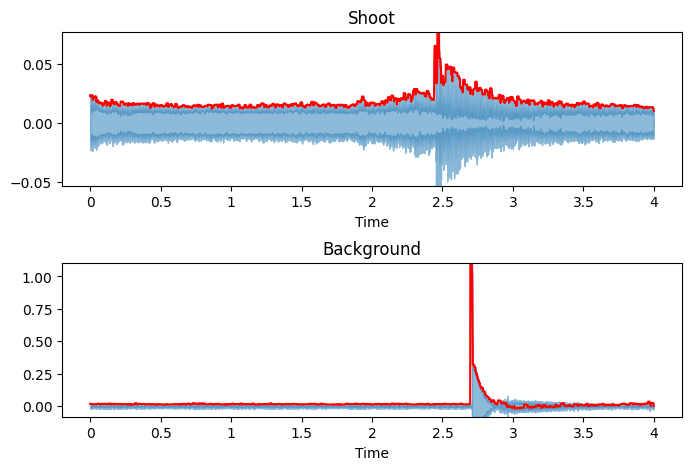

In [43]:
# display waveform and envelope
plot_waveform(shoot_sound, back_sound)

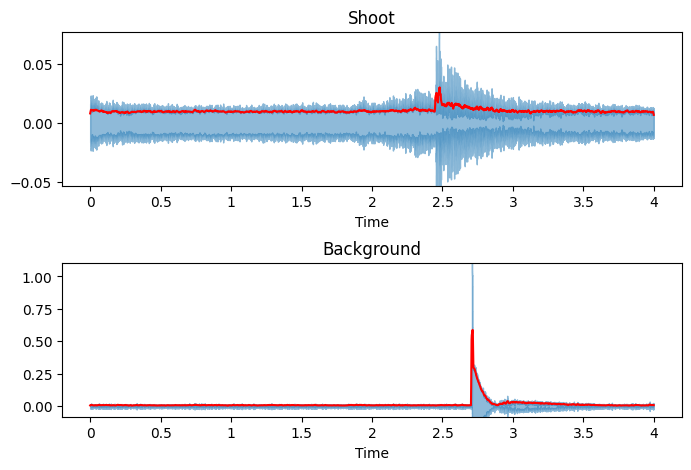

In [44]:
# display root-mean-square energy
plot_rms(shoot_sound, back_sound)

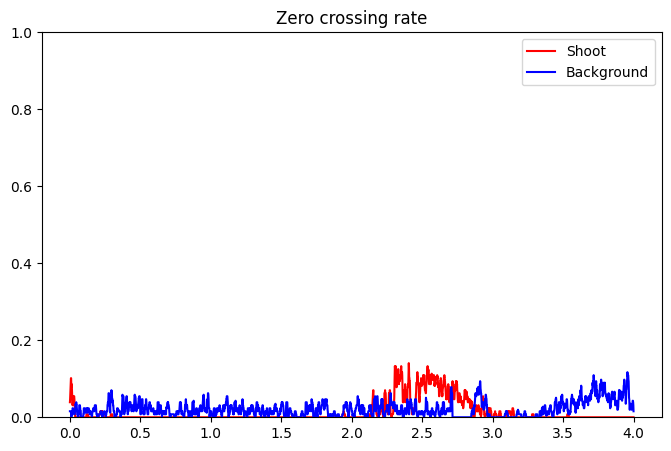

In [45]:
# display zero-crossing-rate
plot_zcr(shoot_sound, back_sound)

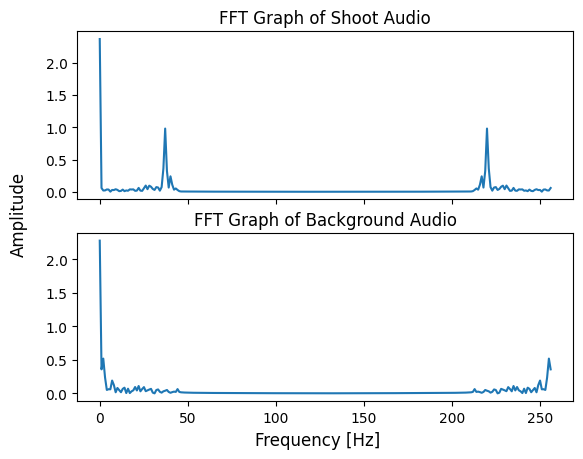

In [46]:
# display frequency response
plot_fft(shoot_sound, back_sound)

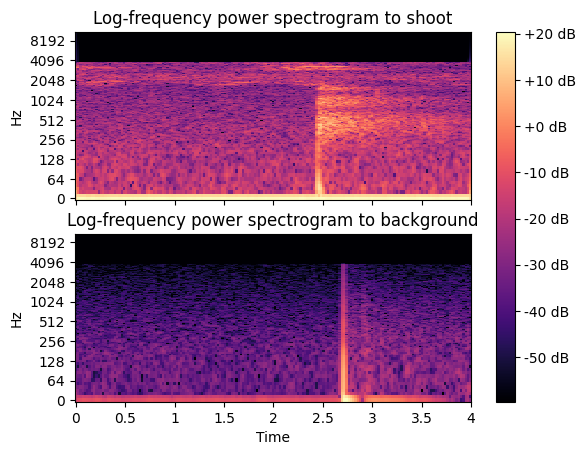

In [47]:
# display spectrogram
plot_spectrogram(shoot_sound, back_sound)